In [33]:
import torch
from torch import nn,optim
from torch.autograd import Variable
from torch.nn import init
from matplotlib import pyplot as plot
import pandas as pd
import numpy as np

## Reading Data

In [34]:
csvfile = pd.read_csv("../steering.csv")

In [35]:
print(csvfile.head(10))

             timestamp     angle  torque      speed
0  1479424214787219361  0.003491  0.1250  22.880556
1  1479424214807231859  0.003491  0.1250  22.886110
2  1479424214827300730  0.003491  0.1250  22.891666
3  1479424214847355643  0.003491  0.1875  22.897223
4  1479424214867355824  0.003491  0.0000  22.902779
5  1479424214887364135  0.003491  0.0625  22.905556
6  1479424214907399816  0.003491  0.2500  22.908333
7  1479424214927455132  0.003491 -0.0625  22.911112
8  1479424214947476806  0.001745  0.0000  22.913889
9  1479424214967638631  0.001745 -0.0625  22.913889


## Display the original angle

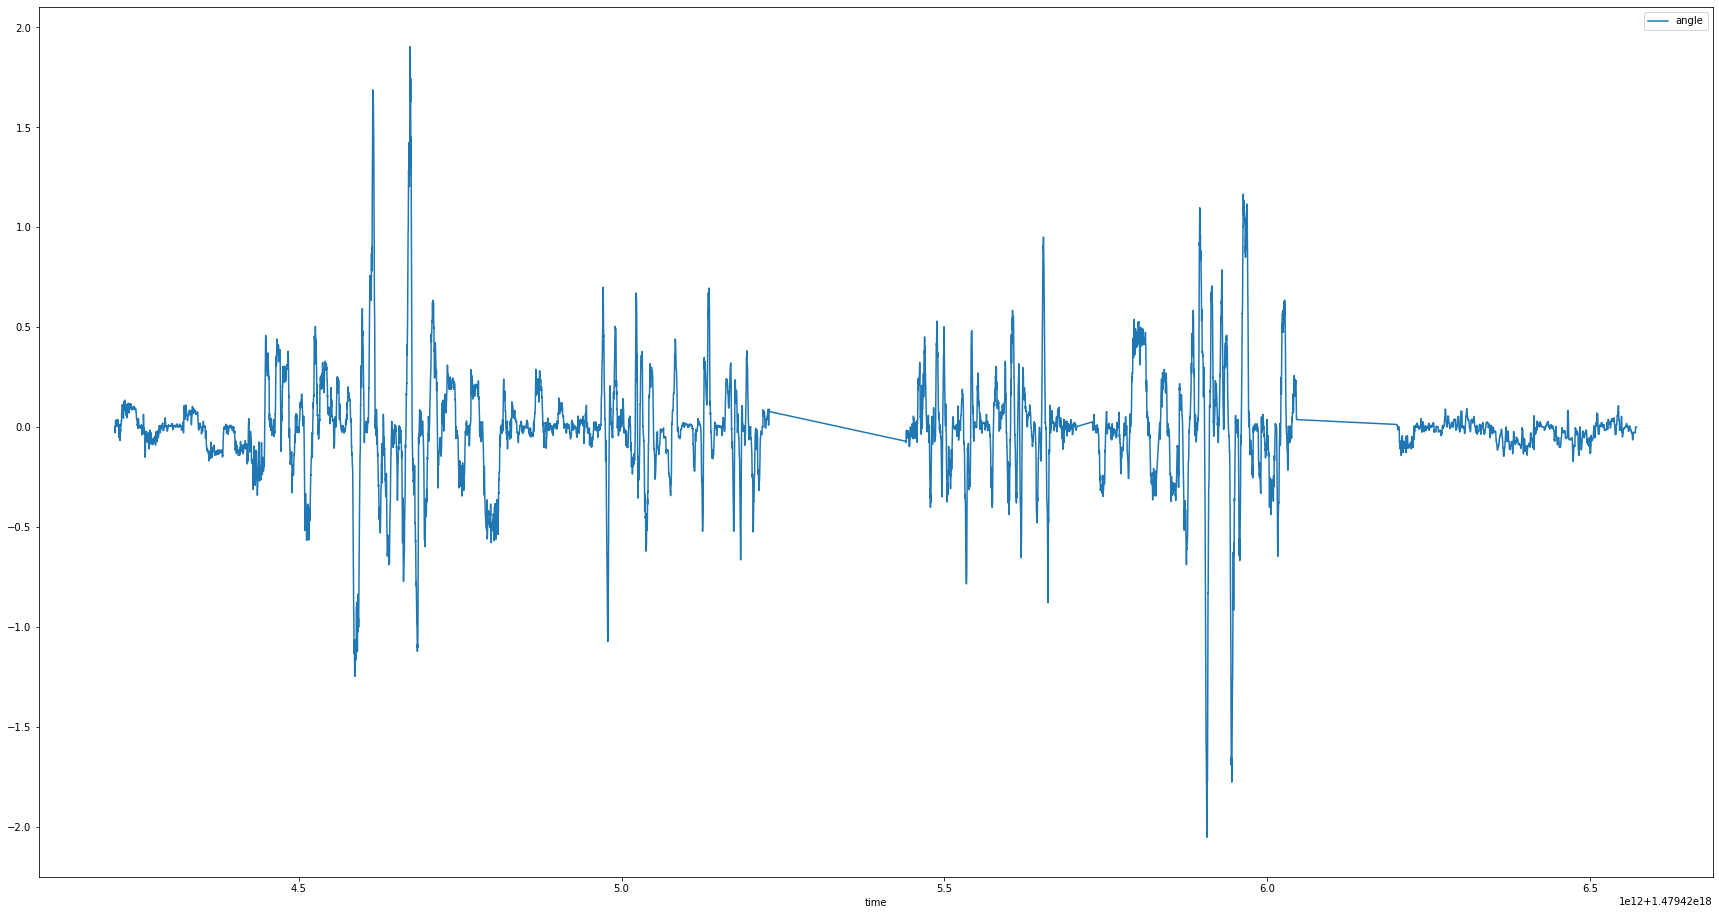

In [36]:
plot.figure(figsize=(30,16))
plot.plot(csvfile.timestamp, csvfile.angle,label='angle')
plot.xlabel("time")
plot.legend()

## Processing Data

In [37]:
angle = csvfile.angle
nums = len(angle)
data = np.array(angle)
data = data.reshape(97887,1)

In [38]:
train_num = nums * 7 //10
validation_num = nums //10
test_num = nums - train_num - validation_num
train_data = data[0:train_num-1]
train_label = data[1:train_num]

In [39]:
validation_data = data[train_num:nums - test_num-1]
validation_label = data[train_num+1: nums - test_num]

In [40]:
test_data = data[train_num+ validation_num:nums-1]
test_label = data[train_num+validation_num+1: nums]

In [41]:
len(validation_data),len(train_data),len(test_data),train_num,validation_num, test_num

(9787, 68519, 19578, 68520, 9788, 19579)

## Model

In [42]:
class rnnModel(nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim,layer_num):
        super().__init__()
        self.fcLayer=nn.Linear(hidden_dim,out_dim)
        self.lstm = nn.LSTM(in_dim, hidden_dim, layer_num)

    def forward(self, x):
        out,_=self.lstm(x)
        out=self.fcLayer(out)
        return  out

    def weightInit(self,gain=1):
        for name ,param in self.named_parameters():
            if 'rnnLayer.weight' in name:
                init.orthogonal(param,gain)


## One sample Training and Testing

In [ ]:
rnn_one=rnnModel(1,20,1,10)
rnn_one = rnn_one.cuda()
criterion_one=nn.MSELoss()
criterion_one = criterion_one.cuda()
optimizer_one=optim.Adam(rnn_one.parameters(),lr=1e-3)
epoches = 500


# Train
for i in range(0, epoches):
    
    #initialize
    initial_data = torch.from_numpy(train_data[0].astype(np.float32)).reshape(1,1,1)
    inputs = initial_data
    outputs_train = []
    loss_train = []
    rnn_one.train()
    for e in range(0, len(train_data)) :
        
        # forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        inputs = output
        
        # loss backforward and optimize
        target = Variable(torch.from_numpy(train_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        optimizer_one.zero_grad()
        loss.backward()
        optimizer_one.step()
        
        loss_train.append(loss.cpu().item())
        outputs_train.append(output.cpu().item())
    print('Epoch [{}/{}],train_loss = {:.10f}'.format(i,epoches, np.mean(loss_train)))  
    
    #validation
    #initialize
    initial_data = torch.from_numpy(validation_data[0].astype(np.float32)).reshape(1,1,1)
    inputs = initial_data
    outputs_val = []
    loss_val = []
    rnn_one.eval()
    with torch.no_grad():
        for e in range(0, len(validation_data)):
            #forward
            inputs = Variable(inputs)
            inputs = inputs.cuda()
            output = rnn_one(inputs)
            outputs_val.append(output.cpu().item())
            inputs = output

            #calculate loss
            target = Variable(torch.from_numpy(validation_label[e].astype(np.float32)).reshape(1,1,1))
            target = target.cuda()
            loss = criterion_one(output, target)
            loss_val.append(loss.cpu().item())
        print('validation_loss = {:.10f}'.format(np.mean(loss_val)))      
    
    
#Test       
    
#initialize
initial_data = torch.from_numpy(test_data[0].astype(np.float32)).reshape(1,1,1)
inputs = initial_data
outputs_test = []
loss_test = []
rnn_one.eval()
with torch.no_grad():
    for e in range(0, len(test_data)):
        #forward
        inputs = Variable(inputs)
        inputs = inputs.cuda()
        output = rnn_one(inputs)
        outputs_test.append(output.cpu().item())
        inputs = output

        #calculate loss
        target = Variable(torch.from_numpy(test_label[e].astype(np.float32)).reshape(1,1,1))
        target = target.cuda()
        loss = criterion_one(output, target)
        loss_test.append(loss.cpu().item())
    print('test_loss = {:.10f}'.format(np.mean(loss_test)))     

Epoch [0/500],train_loss = 0.0050445726
validation_loss = 0.2698698147
Epoch [1/500],train_loss = 0.0074096521
validation_loss = 0.2733450308
Epoch [2/500],train_loss = 0.0055393755
validation_loss = 0.2730608789
Epoch [3/500],train_loss = 0.0043915282
validation_loss = 0.2703363512
Epoch [4/500],train_loss = 0.0048691602
validation_loss = 0.2656707530
Epoch [5/500],train_loss = 0.0046347237
validation_loss = 0.2726701130
Epoch [6/500],train_loss = 0.0035013303
validation_loss = 0.2663158465
Epoch [7/500],train_loss = 0.0019213643
validation_loss = 0.2641828176
Epoch [8/500],train_loss = 0.0018850786
validation_loss = 0.2730506444
Epoch [9/500],train_loss = 0.0014674075
validation_loss = 0.2709154671
Epoch [10/500],train_loss = 0.0016472551
validation_loss = 0.2736637763
Epoch [11/500],train_loss = 0.0025349122
validation_loss = 0.2727653425
Epoch [12/500],train_loss = 0.0015097165
validation_loss = 0.2731204434
Epoch [13/500],train_loss = 0.0030147971
validation_loss = 0.2688329986
Ep

Epoch [114/500],train_loss = 0.0032982430
validation_loss = 0.2685909431
Epoch [115/500],train_loss = 0.0060989359
validation_loss = 0.2756182100
Epoch [116/500],train_loss = 0.0066488105
validation_loss = 0.2704308965
Epoch [117/500],train_loss = 0.0035065306
validation_loss = 0.2690149120
Epoch [118/500],train_loss = 0.0030120668
validation_loss = 0.2680342526
Epoch [119/500],train_loss = 0.0046550066
validation_loss = 0.2683004388
Epoch [120/500],train_loss = 0.0053005946
validation_loss = 0.2713994918
Epoch [121/500],train_loss = 0.0067959700
validation_loss = 0.2603994523
Epoch [122/500],train_loss = 0.0084928609
validation_loss = 0.2746461897
Epoch [123/500],train_loss = 0.0035935822
validation_loss = 0.2731110100
Epoch [124/500],train_loss = 0.0090109571
validation_loss = 0.2763605138
Epoch [125/500],train_loss = 0.0067758028
validation_loss = 0.2700115728
Epoch [126/500],train_loss = 0.0032487841
validation_loss = 0.2676572967
Epoch [127/500],train_loss = 0.0033744249
validatio

validation_loss = 0.2734190847
Epoch [227/500],train_loss = 0.0015955417
validation_loss = 0.2677954545
Epoch [228/500],train_loss = 0.0029260683
validation_loss = 0.2698009557
Epoch [229/500],train_loss = 0.0015709113
validation_loss = 0.2648224821
Epoch [230/500],train_loss = 0.0018501219
validation_loss = 0.2692553460
Epoch [231/500],train_loss = 0.0015069520
validation_loss = 0.2686583746
Epoch [232/500],train_loss = 0.0018760890
validation_loss = 0.2717053259
Epoch [233/500],train_loss = 0.0019156876
validation_loss = 0.2684101230
Epoch [234/500],train_loss = 0.0015535132
validation_loss = 0.2699474651
Epoch [235/500],train_loss = 0.0013664516
validation_loss = 0.2732117214
Epoch [236/500],train_loss = 0.0021384353
validation_loss = 0.2734309924
Epoch [237/500],train_loss = 0.0022341645
validation_loss = 0.2675396683
Epoch [238/500],train_loss = 0.0022232284
validation_loss = 0.2724368499
Epoch [239/500],train_loss = 0.0011136043
validation_loss = 0.2680039530
Epoch [240/500],trai

Epoch [339/500],train_loss = 0.0062339350
validation_loss = 0.2596553001
Epoch [340/500],train_loss = 0.0030785365
validation_loss = 0.2730384115
Epoch [341/500],train_loss = 0.0043688653
validation_loss = 0.2708593064
Epoch [342/500],train_loss = 0.0048317779
validation_loss = 0.2711969105
Epoch [343/500],train_loss = 0.0025844073
validation_loss = 0.2692050108
Epoch [344/500],train_loss = 0.0023254663
validation_loss = 0.2693964246
Epoch [345/500],train_loss = 0.0028064910
validation_loss = 0.2741943567
Epoch [346/500],train_loss = 0.0021057583
validation_loss = 0.2694541831
Epoch [347/500],train_loss = 0.0023338032
validation_loss = 0.2733363785
Epoch [348/500],train_loss = 0.0035870318
validation_loss = 0.2696762217
Epoch [349/500],train_loss = 0.0019789424
validation_loss = 0.2720779998
Epoch [350/500],train_loss = 0.0022832010
validation_loss = 0.2727047207
Epoch [351/500],train_loss = 0.0016187667
validation_loss = 0.2619306690
Epoch [352/500],train_loss = 0.0019154806
validatio

## Training graph of Predicted Data and Ground Truth

In [ ]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_train)), outputs_train,label='predict_angle')
plot.plot(range(0,len(outputs_train)), train_label,label='ground truth')
plot.xlabel("steps")

plot.legend()

## Testing graph of Predicted Data and Ground Truth

In [ ]:
plot.figure(figsize=(30,16))
plot.plot(range(0,len(outputs_test)), outputs_test,label='predict_angle')
plot.plot(range(0,len(outputs_test)), test_label,label='ground truth')
plot.xlabel("steps")
plot.legend()